In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import pickle
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('ggplot')

In [2]:
class NN_function(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NN_function, self).__init__()
        self._f = tf.keras.Sequential(
          [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
          [tf.keras.layers.Dense(1)])

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        # Tile all possible combinations of x and y
        x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
        # xy is [batch_size * batch_size, x_dim + y_dim]
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        # Compute scores for each x_i, y_j pair.
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))

In [3]:
def batch_adj(batch_size):
    """This is to adjust the mean value of the marginals.
    
    We use the method from the orginal colab by Ben Poole, which subtracts the main diagonal,
    to get the marginals. However, the mean value is then over all values N (also the zeros),
    instead of M marginals. The original code solves this by introducing a new logsumexp function.
    
    We solve the problem as follows: Note that the sum over the zeros doesnt matter, therefore,
    due to 1/N sum_N (), we only need to adjust the front N, to M, by multiplying with N/M.
    """
    return ((batch_size*batch_size)/(batch_size*(batch_size-1.)))
    

def infonce_lower_bound(scores):
    """InfoNCE lower bound on MI from van den Oord et al. (2018)."""
    nll = tf.reduce_mean(tf.linalg.diag_part(scores) - tf.reduce_logsumexp(scores, axis=1))  
    mi = tf.math.log(tf.cast(scores.shape[0], tf.float32)) + nll
    return mi

def nwj_lower_bound(scores):
    """NWJ lower bound on MI from Nguyen et al. (2010)"""
    def marg(x):
        batch_size = x.shape[0]
        c = batch_adj(batch_size)
        marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
        return marg_*c
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores-1.))
    marg_term = marg(scores-1.)
    return 1. + joint_term - marg_term

def RJ_MIE(scores):
    """RJE lower bound on MI from Fritschek et al. (2020)"""
    tau = 6.
    a = 2.#1.+np.e**(-8)
    b = 1.
    factor = a/(1.-tf.sqrt(b/a))
    def marg(x):
        batch_size = x.shape[0]
        c = batch_adj(batch_size)
        expf = tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size)))
        fac = (tf.reduce_mean(expf+expf)*c)/((c*tf.reduce_mean(expf))**2)
        marg_ = factor*fac*tf.reduce_mean(tf.math.log(1.+a*fac*expf))
        return marg_*c-tf.math.log(a*fac)
    scores = tf.clip_by_value(scores, clip_value_min=-tau, clip_value_max=tau)
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - marg_term

def nwj2_lower_bound(scores):
    def marg(x):
        batch_size = x.shape[0]
        c = batch_adj(batch_size)
        marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
        return marg_*c
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - marg_term*(1/np.e)

def MINE_lower_bound(scores):
    """MINE approximation on MI from Belghazi et al. (2018)"""
    def marg(x):
        batch_size = x.shape[0]
        c = batch_adj(batch_size)
        marg_ = tf.reduce_mean(tf.exp(x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))))
        return marg_*c
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - tf.math.log(marg_term)

def SMILE_lower_bound(scores):
    """SMILE lower bound on MI from Jiaming Song et al. (2020).
    This version clips the score"""
    scores = tf.clip_by_value(scores, clip_value_min=-7, clip_value_max=7)
    def marg(x):
        batch_size = x.shape[0]
        c = batch_adj(batch_size)
        #x_clip = tf.clip_by_value(x, clip_value_min=-2, clip_value_max=2)
        exp_x = tf.exp(x- tf.linalg.tensor_diag(np.inf * tf.ones(batch_size)))
        marg_ = tf.reduce_mean(exp_x)*c
        return marg_
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - tf.math.log(marg_term)

def SMILE2_lower_bound(scores):
    """SMILE lower bound on MI from Jiaming Song et al. (2020).
    This version clips only the marginal score"""
    tau=5
    def marg(x):
        batch_size = x.shape[0]
        c = batch_adj(batch_size)
        x_clip = tf.clip_by_value(x, clip_value_min=-tau, clip_value_max=tau)
        exp_x = tf.exp(x_clip- tf.linalg.tensor_diag(np.inf * tf.ones(batch_size)))
        marg_ = tf.reduce_mean(exp_x)*c
        return marg_
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = marg(scores)
    return joint_term - tf.math.log(marg_term)

def js_fgan_lower_bound(f):
    """Lower bound on Jensen-Shannon divergence from Nowozin et al. (2016)."""
    f_diag = tf.linalg.tensor_diag_part(f)
    first_term = tf.reduce_mean(-tf.nn.softplus(-f_diag))
    n = tf.cast(f.shape[0], tf.float32)
    second_term = (tf.reduce_sum(tf.nn.softplus(f)) - tf.reduce_sum(tf.nn.softplus(f_diag))) / (n * (n - 1.))
    return first_term - second_term

def js_lower_bound(f):
    """NWJ lower bound on MI using critic trained with Jensen-Shannon.
    The returned Tensor gives MI estimates when evaluated, but its gradients are
    the gradients of the lower bound of the Jensen-Shannon divergence."""
    js = js_fgan_lower_bound(f)
    mi = nwj_lower_bound(f)
    return js + tf.stop_gradient(mi - js)

def js_smile_lower_bound(f):
    """SMILE lower bound on MI using critic trained with Jensen-Shannon."""
    js = js_fgan_lower_bound(f)
    mi = SMILE2_lower_bound(f)
    return js + tf.stop_gradient(mi - js)

In [4]:
def sample_AWGN_channel(batch_size, dim, SIGNAL_NOISE = 0.5, SIGNAL_POWER = 2):
    """Simple additive white Gaussian noise channel"""
    x_sample = tf.random.normal((batch_size, dim), stddev = np.sqrt(SIGNAL_POWER))
    y_sample = x_sample + tf.random.normal((batch_size, dim), stddev = np.sqrt(SIGNAL_NOISE))   
    
    return tf.cast(x_sample, tf.float32), tf.cast(y_sample, tf.float32)

def sample_Rayleigh_channel(batch_size, dim, SIGNAL_NOISE = 0.5, SIGNAL_POWER = 2):
    """Rayleigh channel, where the factor h is known (estimated) and the received signal scaled"""
    x_sample = tf.random.normal((batch_size, dim), stddev = np.sqrt(SIGNAL_POWER))
    h_sample = np.sqrt(np.random.randn(batch_size, dim)**2+np.random.randn(batch_size, dim)**2)
    z_sample = tf.random.normal((batch_size, dim), stddev = np.sqrt(SIGNAL_NOISE))
    
    y_sample = x_sample + tf.divide(z_sample,h_sample)
    
    return tf.cast(x_sample, tf.float32), tf.cast(y_sample, tf.float32), h_sample

def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128):
    """Metric from MINE and following papers"""
    x, eps = tf.split(tf.random.normal((batch_size, 2 * dim)), 2, axis=1)
    y = rho * x + tf.sqrt(tf.cast(1. - rho**2, tf.float32)) * eps
    return x, y

def sample_bsc(batch_size, pz=0.11):
    """Binary symmetric channel;
    Default values: for pz=0.11, the MI should be roughly 0.5"""
    x_sample = tf.keras.backend.random_binomial((batch_size,1),p=0.5)
    z_sample = tf.keras.backend.random_binomial((batch_size,1),p=pz)
    y_sample = tf.math.mod(tf.add(x_sample,z_sample),2)
    return x_sample, y_sample

In [5]:
data_vars = {
    'iterations': 4000,
    'batch_size' : 64,
}
critic_params = {
    'layers': 2,
    'hidden_dim': 256,
    'activation': 'relu',
}

estimators = {'JS smile Estimator': 'js_smile', 'NWJ Estimator': 'nwj',  'RJE': 'RJE', 'MINE Estimator':'mine'}

In [6]:
def train_estimator(estimator, est_name, batch_size=64, iterations=1000):

    opt = tf.keras.optimizers.Nadam()
    @tf.function
    def train_batches(batch_size):
        with tf.GradientTape() as tape:
            x, y = sample_AWGN_channel(batch_size, 8)
            #x, y = sample_correlated_gaussian(rho=0.7, dim=20, batch_size=batch_size)
            #x,y = sample_bsc(batch_size=batch_size, pz=0.11)
            #x,y,h = sample_Rayleigh_channel(batch_size, 5)
            scores = estimator(x,y)
            
            if est_name == "NWJ Estimator":
                mi = nwj_lower_bound(scores)
            elif est_name == "NCE Estimator":
                mi = infonce_lower_bound(scores)
            elif est_name == "smile_bound":
                mi = SMILE_lower_bound(scores)
            elif est_name == "MINE Estimator":
                mi = MINE_lower_bound(scores)
            elif est_name == "JS smile Estimator":
                mi = js_smile_lower_bound(scores)
            elif est_name == "js_bound":
                mi = js_lower_bound(scores)
            elif est_name == "RJE":
                mi = RJ_MIE(scores)
                
            loss = - mi
                    
            grads = tape.gradient(loss, estimator.trainable_variables)
            opt.apply_gradients(zip(grads, estimator.trainable_variables))
        return mi
        
    estimates = []

    for i in range(iterations):
        estimates.append(train_batches(batch_size).numpy())
        if (i % (iterations/10) == 0):
            print(i)
    estimates = np.array(estimates)
    return estimates

In [7]:
estimates = {}
for estimator in estimators:
    estimators[estimator] = NN_function(**critic_params)
    estimates[estimator] = train_estimator(estimators[estimator], estimator, **data_vars)

0
400
800
1200
1600
2000
2400
2800
3200
3600
0
400
800
1200
1600
2000
2400
2800
3200
3600
0
400
800
1200
1600
2000
2400
2800
3200
3600
0
400
800
1200
1600
2000
2400
2800
3200
3600


In [8]:
def theoretic_mutual_information_AWGN(power, noise, dim):
    return dim * 0.5 * np.log2(1 + power/noise)

def rho_to_mi(dim, rho):
    return -0.5  * np.log2(1-rho**2) * dim

<Figure size 2880x720 with 0 Axes>

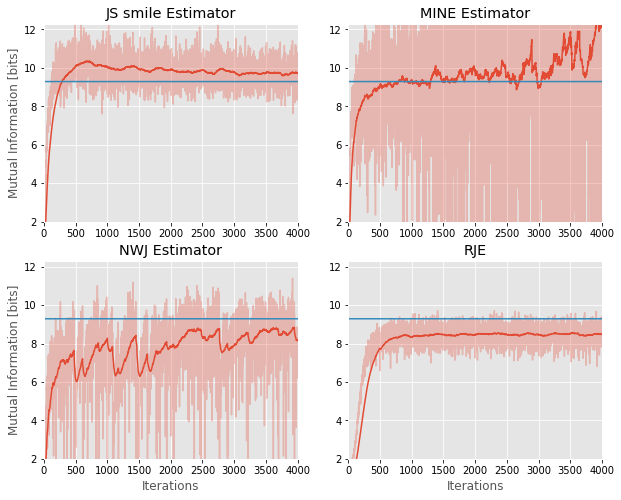

In [21]:
th_mi = theoretic_mutual_information_AWGN(2, 0.5,8)

plt.figure(figsize=(40,10))
names = np.sort(list(estimators.keys()))
nrows = min(2, len(estimates))
ncols = int(np.ceil(len(estimates) / float(nrows)))
fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4  * nrows))
if len(estimates) == 1:
    axs = [axs]
axs = np.ravel(axs)

for i, name in enumerate(names):
    plt.sca(axs[i])
    plt.title(names[i])
    mis = estimates[name]
    mis_smooth = pd.Series(np.log2(np.exp(1))*mis).ewm(span=200).mean()
    p1 = plt.plot(np.log2(np.exp(1))*mis, alpha=0.3)[0]
    plt.plot(mis_smooth, c=p1.get_color())
    plt.plot([th_mi]*data_vars['iterations'])
    plt.tick_params(axis='x', colors='black')
    plt.tick_params(axis='y', colors='black')
    plt.ylim(2, th_mi+3)
    plt.xlim(0, data_vars['iterations'])
    axs[0].set_ylabel('Mutual Information [bits]')
    axs[2].set_ylabel('Mutual Information [bits]')
    axs[2].set_xlabel('Iterations')
    axs[3].set_xlabel('Iterations')
plt.savefig('Estimator_comparison_rje_t6_8dim_snr4.pdf')